In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gett-insights/data_orders.csv
/kaggle/input/gett-insights/data_offers.csv


# Goals
1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?

BONUS Topic (Hexagons). Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

The data_orders data set contains the following columns:
* order_datetime - time of the order
* origin_longitude - longitude of the order
* origin_latitude - latitude of the order
* m_order_eta - time before order arrival
* order_gk - order number
* order_status_key - status, an enumeration consisting of the following mapping:
    * 4 - cancelled by client,
    * 9 - cancelled by system, i.e., a reject
* is_driver_assigned_key - whether a driver has been assigned
* cancellation_time_in_seconds - how many seconds passed before cancellation

The data_offers data set contains the following columns:
* order_gk - order number, associated with the same column from the orders data set (job being requested)
* offer_id - ID of an offer (driver accepting the job)

In [100]:
#Had to install h3 and folium in the environment before I could import them
# !pip install h3 folium

In [146]:
#Basic imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime


#graphing imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#question 5 imports
#h3-py, often referred to as H3, is a Python library that provides bindings for Uber's H3 core library, which is written in C. H3 is 
#a geospatial indexing system that partitions the world into a hierarchical grid of hexagonal cells.
import h3

#folium is a Python library that leverages the capabilities of Leaflet.js to create interactive maps. It enables the visualization of data manipulated in Python on a web-based map.
import folium

#json, geojson and h3 basic_int
import json
import geojson
import h3.api.basic_int as h3  # using the integer-based API

# 1 Data Investigation

In [102]:
orders = pd.read_csv('/kaggle/input/gett-insights/data_orders.csv')

In [103]:
#data shape
orders.shape

(10716, 8)

In [104]:
#random sample of the dataset
orders.sample(n=10, random_state = 20)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
3076,17:22:05,-0.968179,51.420983,NaN,3000624967903,4,0,117.0
8357,08:03:02,-0.978261,51.457424,NaN,3000589082032,4,0,196.0
62,17:12:18,-0.963187,51.450644,NaN,3000632347310,4,0,15.0
5894,20:40:25,-0.966443,51.444531,NaN,3000623116232,4,0,39.0
100,09:19:54,-0.984726,51.445691,NaN,3000622820005,4,0,9.0
4401,08:48:13,-0.974281,51.475314,NaN,3000632147104,9,0,NaN
1685,18:28:23,-0.971995,51.457894,898.0,3000594346091,4,1,102.0
5171,20:37:48,-0.922706,51.442083,538.0,3000630056224,4,1,47.0
2600,22:00:16,-0.977171,51.467298,299.0,3000580101421,4,1,182.0
6842,14:13:37,-0.969582,51.451689,478.0,3000630532207,4,1,618.0


In [105]:
#missing values in 2 fields (m_order_eta and cancellation_time_in_seconds)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [106]:
offers = pd.read_csv('/kaggle/input/gett-insights/data_offers.csv')

In [107]:
#data shape
offers.shape

(334363, 2)

In [108]:
#random sample of dataset
offers.sample(n = 10, random_state = 20)

,order_gk,offer_id
83657,3000555895749,300050733543
147216,3000617525955,300051721172
191970,3000579376175,300050925639
299625,3000588657559,300051229279
175643,3000588506052,300051219383
109547,3000597861008,300051589006
76409,3000632822411,300052401029
130675,3000595621316,300051538951
333202,3000592195716,300051363088
198400,3000628030924,300052119709


In [109]:
#No null values found
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


# 2 Merge + Data Cleaning

Merge the datasets

In [110]:
df = orders.merge(offers, how='inner', on='order_gk')

In [111]:
df.sample(n=10, random_state=20)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
17207,23:48:51,-0.952027,51.451726,NaN,3000623191607,9,0,NaN,300051835104
14513,03:02:55,-0.949574,51.451789,NaN,3000625916059,9,0,NaN,300052010738
25632,16:48:08,-0.984550,51.422450,958.0,3000583666547,4,1,884.0,300051020652
3697,18:00:41,-0.945101,51.444783,NaN,3000631282078,4,0,107.0,300052342434
21173,00:15:44,-0.962288,51.439495,1081.0,3000590782265,4,1,258.0,300051336532
26228,10:00:35,-0.996736,51.458982,NaN,3000583492613,4,0,113.0,300051008013
27745,08:15:43,-0.955637,51.470372,NaN,3000577152554,4,0,257.0,300050808791
22949,13:00:27,-0.971995,51.457894,NaN,3000579226786,4,0,87.0,300050918525
18548,21:38:23,-0.944698,51.454115,NaN,3000595071501,9,0,NaN,300051520523
29420,02:53:03,-0.964747,51.454639,NaN,3000617675875,4,0,180.0,300051731340


Replace some numeric values to more representative categorical names

In [112]:
df['is_driver_assigned'] = np.where(df['is_driver_assigned_key'] == 1, 'Yes', 'No')
df['order_status'] = np.where(df['order_status_key'] == 4, 'Client Cancelled', 'System Reject')

df = df.drop(columns = ['is_driver_assigned_key', 'order_status_key'])

In [113]:
df = df.rename(columns={'order_datetime':'order_time'})

In [114]:
df.sample(n=5, random_state=20)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
17207,23:48:51,-0.952027,51.451726,NaN,3000623191607,NaN,300051835104,No,System Reject
14513,03:02:55,-0.949574,51.451789,NaN,3000625916059,NaN,300052010738,No,System Reject
25632,16:48:08,-0.984550,51.422450,958.0,3000583666547,884.0,300051020652,Yes,Client Cancelled
3697,18:00:41,-0.945101,51.444783,NaN,3000631282078,107.0,300052342434,No,Client Cancelled
21173,00:15:44,-0.962288,51.439495,1081.0,3000590782265,258.0,300051336532,Yes,Client Cancelled


# Questions

## Question 1
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

### Answer 1
There are only a few combinations possible here due to the nature of the data, so first we generate a simple table reviewing the driver assignment and cancellation reasons in conjuction with quantities of cancellations

In [115]:
df.groupby(['is_driver_assigned', 'order_status'])['order_gk'].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

It appears the majority of cancellations are before a driver is assigned, with almost 50% more client cancellations than system rejections.

We can also review the data visually using a pivot table

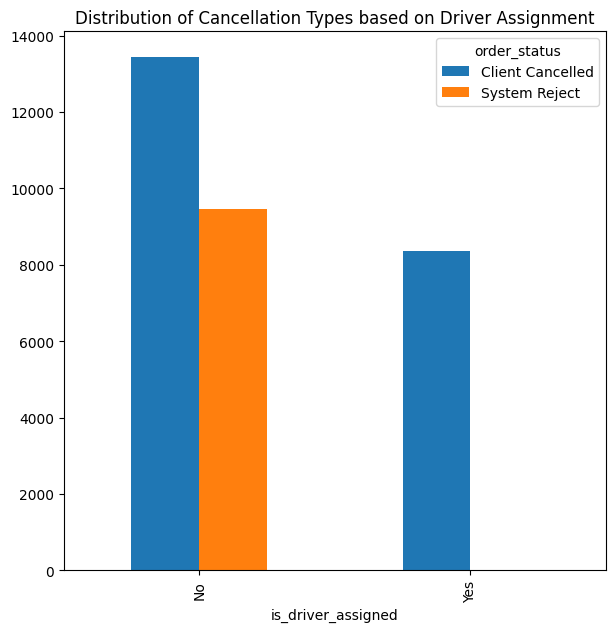

In [116]:
df_canc_piv1 = df.pivot_table(index=['is_driver_assigned'], columns=['order_status'], values='order_gk', aggfunc='count')
#df_canc_piv
df_canc_chart1 = df_canc_piv1.plot(kind='bar', subplots=False, figsize=(7,7), legend=True, title = 'Distribution of Cancellation Types based on Driver Assignment')

In [117]:
df_canc_piv1

order_status,Client Cancelled,System Reject
is_driver_assigned,,
No,13435,9469
Yes,8360,4


## Question 2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?


### Answer 2
First step is to isolate the hour of day for each entry in the data set

In [118]:
df['order_time'] = pd.to_datetime(df.order_time)

In [119]:
df['order_hour'] = df.order_time.dt.hour

In [120]:
#confirming the datetime conversion and new hour field worked
df.sample(n=5, random_state=20)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
17207,2025-04-24 23:48:51,-0.952027,51.451726,NaN,3000623191607,NaN,300051835104,No,System Reject,23
14513,2025-04-24 03:02:55,-0.949574,51.451789,NaN,3000625916059,NaN,300052010738,No,System Reject,3
25632,2025-04-24 16:48:08,-0.984550,51.422450,958.0,3000583666547,884.0,300051020652,Yes,Client Cancelled,16
3697,2025-04-24 18:00:41,-0.945101,51.444783,NaN,3000631282078,107.0,300052342434,No,Client Cancelled,18
21173,2025-04-24 00:15:44,-0.962288,51.439495,1081.0,3000590782265,258.0,300051336532,Yes,Client Cancelled,0


Grouping by hour, then plotting the results

In [121]:
df.groupby(['order_hour'])['order_gk'].count().head()

order_hour
0    1993
1    1305
2    1475
3    1418
4     227
Name: order_gk, dtype: int64

<Axes: title={'center': 'Count of Failed Orders by Hour of Day'}, xlabel='order_hour'>

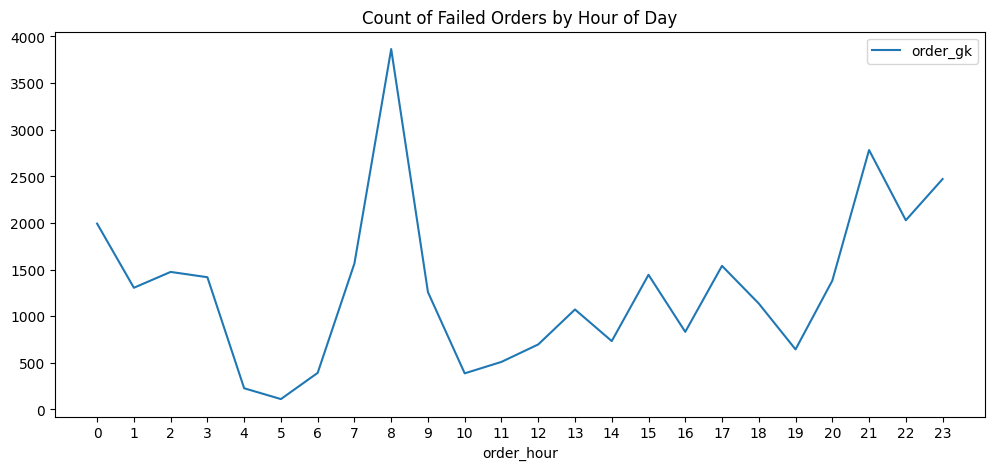

In [122]:
df.groupby('order_hour').order_gk.count().plot(figsize = (12,5), legend=True, xticks=range(0,24), title='Count of Failed Orders by Hour of Day')

We've isolated a few high cancellation volume hours (8, 21-23), now let's drill down a bit further to look for 

In [123]:
df.groupby(['order_hour', 'is_driver_assigned', 'order_status'])['order_gk'].count().head(10)

order_hour  is_driver_assigned  order_status    
0           No                  Client Cancelled    957
                                System Reject       706
            Yes                 Client Cancelled    326
                                System Reject         4
1           No                  Client Cancelled    633
                                System Reject       374
            Yes                 Client Cancelled    298
2           No                  Client Cancelled    586
                                System Reject       649
            Yes                 Client Cancelled    240
Name: order_gk, dtype: int64

In [124]:
df_canc_piv2 = df.pivot_table(index=['order_hour'], columns=['is_driver_assigned', 'order_status'], values='order_gk', aggfunc='count')

<Axes: title={'center': 'Count of Failed Orders by Hour of Day + Category'}, xlabel='order_hour', ylabel='Count'>

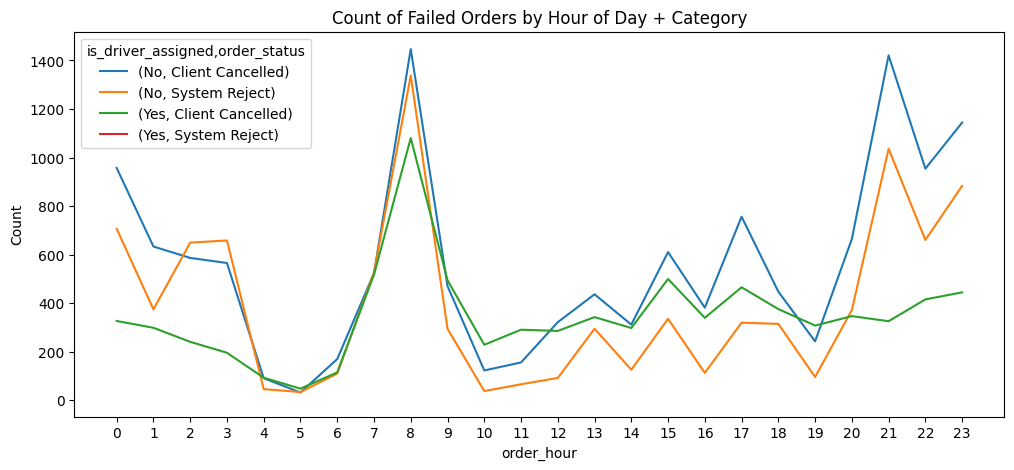

In [125]:
df_canc_piv2.plot(figsize=(12,5), ylabel='Count', xticks=range(0,24), legend=True, title='Count of Failed Orders by Hour of Day + Category')

In [126]:
df_canc_piv2.head(10)

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_hour                                                           
0                             957.0         706.0            326.0   
1                             633.0         374.0            298.0   
2                             586.0         649.0            240.0   
3                             565.0         658.0            195.0   
4                              90.0          45.0             92.0   
5                              31.0          33.0             47.0   
6                             169.0         109.0            114.0   
7                             523.0         526.0            517.0   
8                            1447.0        1338.0           1080.0   
9                             470.0         294.0            494.0   

is_driver_assigned                
order_status       System Reject  
order_hour                        
0                            4.0  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN  
5                            NaN  
6                            NaN  
7                            NaN  
8                            NaN  
9                            NaN

The 4 cases (line marked as red) can be seen in the pivot chart / groupby output at hour 0 (midnight), but will not appear in the charts

## Question 3
Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

### Answer 3

First we sample the group by for order_hour and is_driver_assigned.

In [127]:
df.groupby(['order_hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean().head(10)

order_hour  is_driver_assigned
0           No                    115.126437
            Yes                   276.082822
1           No                    100.593997
            Yes                   296.312081
2           No                    121.305461
            Yes                   301.466667
3           No                    129.182301
            Yes                   368.682051
4           No                    100.733333
            Yes                   245.250000
Name: cancellations_time_in_seconds, dtype: float64

In order to make better sense of this, we need to chart the information by hour of day

<Axes: title={'center': 'Mean Cancellation Time by Hour of Day + Category'}, xlabel='order_hour', ylabel='Mean Cancellation Time'>

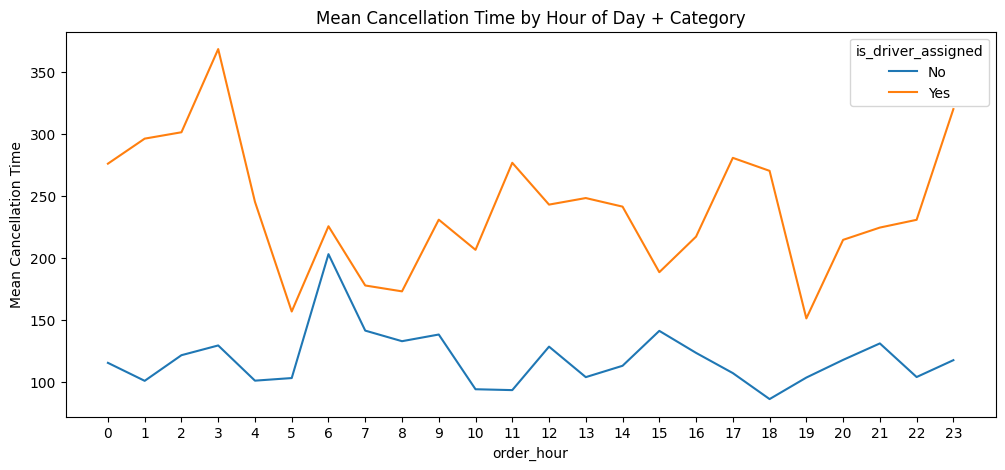

In [128]:
df_canc_piv3 = df.pivot_table(index='order_hour', columns=['is_driver_assigned'], values='cancellations_time_in_seconds', aggfunc='mean')
df_canc_piv3.plot(figsize=(12,5), ylabel='Mean Cancellation Time', xticks=range(0,24), legend=True, title='Mean Cancellation Time by Hour of Day + Category')

Mean cancellation time is consistently much higher once a driver is assigned, especially in hours centering around midnight. 

This could indicate a desparation for a ride (willing to wait longer) as well as a absence of sufficient supply of drivers. Would need the "average_time_to_accept" data point to evaluate further.

## Question 4
Plot the distribution of average ETA by hours. How can this plot be explained?

### Answer 4
We can simply use a groupby statement to answer this question, and then pipeline the df to a plot

In [129]:
avg_etas = df.groupby('order_hour')['m_order_eta'].mean()
avg_etas

order_hour
0     375.433333
1     355.322148
2     389.554167
3     381.492308
4     266.119565
5     476.787234
6     489.456140
7     642.746615
8     671.086111
9     556.085020
10    424.969298
11    405.837931
12    504.691228
13    445.228070
14    406.383838
15    518.218437
16    456.958702
17    548.673118
18    421.725333
19    396.850163
20    299.627168
21    365.630769
22    365.896386
23    386.078829
Name: m_order_eta, dtype: float64

<Axes: title={'center': 'Average ETA per Hour of Day'}, xlabel='order_hour', ylabel='ETA in Seconds'>

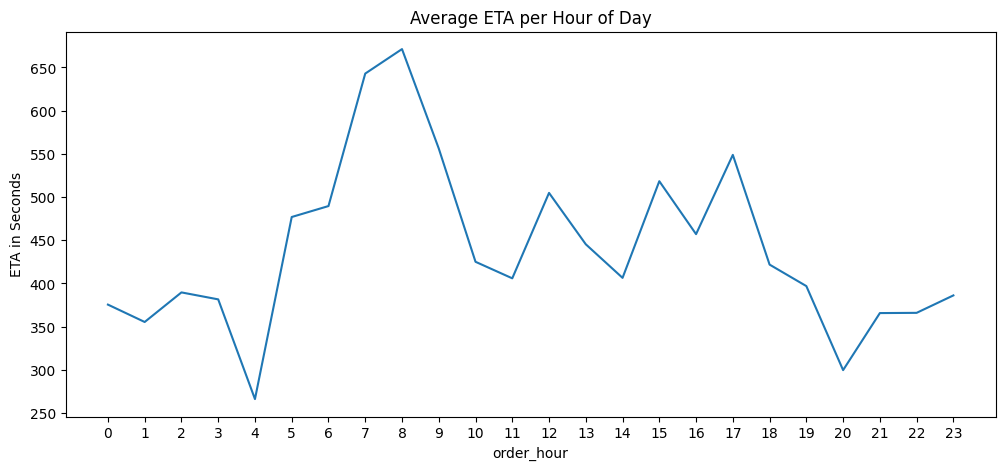

In [130]:
avg_etas.plot(figsize=(12,5), ylabel='ETA in Seconds', xticks=range(0,24), title='Average ETA per Hour of Day')

Just out of curiosity before the bonus question is addressed, I decided to look into the ETAs broken down by region

In [131]:
#eta_piv1 = df.pivot_table(index='order_hour', columns=[''], values='m_order_eta', aggfunc='mean')

## Question 5
Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

### Answer 5

In [132]:
#create hex_id field
df['hex_id'] = df.apply(func=lambda row: h3.latlng_to_cell(lat=row['origin_latitude'], lng=row['origin_longitude'], res=8), axis=1)

In [133]:
#group by hex_id to find count or orders
hex_grps = df.groupby('hex_id')['order_gk'].count().reset_index()
hex_grps.shape

(139, 2)

In [134]:
hex_grps.sample(n=5, random_state=20)

,hex_id,order_gk
87,88195d2b11fffff,2191
44,88195d2967fffff,8
66,88195d2a33fffff,12
127,88195d39bbfffff,2
20,88195d284dfffff,1937


We'll use a cumulative sum function to sort out which hex regions make up the top 80% of ride orders

In [135]:
#sort values from highest to lowest order_gk
hex_grps = hex_grps.sort_values(by='order_gk', ascending=True)
hex_grps.head(5)

,hex_id,order_gk
137,88195d74d5fffff,1
135,88195d74d1fffff,1
79,88195d2aebfffff,1
11,88195d282bfffff,1
122,88195d3993fffff,1


In [136]:
#find total orders
tot_orders = hex_grps.order_gk.sum()
tot_orders

31268

In [137]:
#add cumulative_sum and cumulative_perc and filter to top 80%
hex_grps['cumulative_sum'] = hex_grps.order_gk.cumsum()
hex_grps['cumulative_perc'] = hex_grps.cumulative_sum / tot_orders
hex_grps = hex_grps[hex_grps.cumulative_perc <= .8]
hex_grps.shape

(137, 4)

2 of the hex regions are eliminated by the 80% filtering, meaning the first 137 / 139 regions (98.5%) make up 80% of the geography.
Note: This is starting from an ascending order perspective. If we start with a descending order perspective, we arrive at a very different number of 20/137 (14.6% of regions making up 80% mark)

In [153]:
#create the folium map with a centralized location and zoom start
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=12,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [145]:
def to_geojson(row):
    """Transform hex_id into a GeoJSON feature."""
    # Convert hex string to integer (required by basic_int API)
    int_cell = int(row["hex_id"], 16)

    # Get boundary in [lat, lng], flip to [lng, lat] for GeoJSON
    latlngs = h3.cell_to_boundary(int_cell)
    lnglats = [[lng, lat] for lat, lng in latlngs]

    geometry = {
        "type": "Polygon",
        "coordinates": [lnglats]
    }

    return geojson.Feature(
        id=row["hex_id"],
        geometry=geometry,
        properties={"order_gk": row["order_gk"]}
    )

# Apply function row-wise and collect GeoJSON features
geojsons = hex_grps.apply(to_geojson, axis=1).tolist()
geojson_str = json.dumps(geojson.FeatureCollection(geojsons))

In [147]:
colormap = matplotlib.colormaps['plasma']
max_order_gk = hex_grps.order_gk.max()
min_order_gk = hex_grps.order_gk.min()

In [155]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [156]:
map